# EXPLORATION_16. 프로젝트 : SRGAN 활용하기

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
### 프로젝트 1-1
- 직접 고른 이미지에 대해 SRGAN을 적용해보기
- 테스트할 이미지를 고를 때, DIV2K 의 학습 데이터셋과 비슷한 종류의 이미지가 좋다.
- 특정 데이터셋에서만 학습되었기 때문에, 일반적으로 좋지 않은 결과가 나올 가능성이 높다.

In [12]:
import os
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

(413, 600, 3)


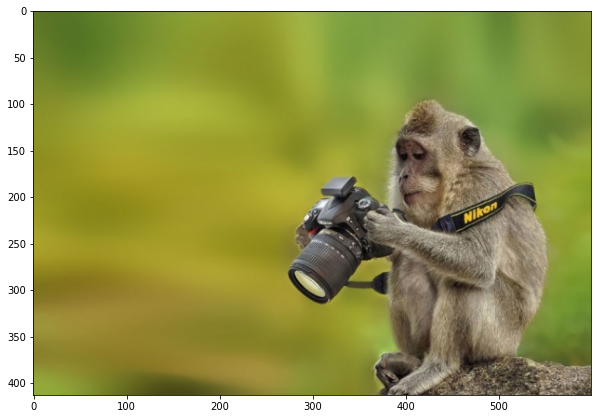

In [13]:
hr_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/mo.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(10,8))
plt.imshow(hr_image)

**1. 불러온 이미지가 꽤나 선명하기 때문에 일부러 크기를 줄여 저해상도로 낮춰본다.**
- opencv 라이브러리의 resize()를 이용해 이미지의 크기를 조절할수 있다.
- 아래 코드에서는 고양이를 '100 x 150 x 3' 크기로 줄인다.
- dsize의 설정값에 따라 크기를 조절하는데, 주의할 점은 변환하고자 하는 이미지의 크기를 (가로 픽셀 수, 세로 픽셀 수) 로 지정해줘야한다.*

(103, 150, 3)


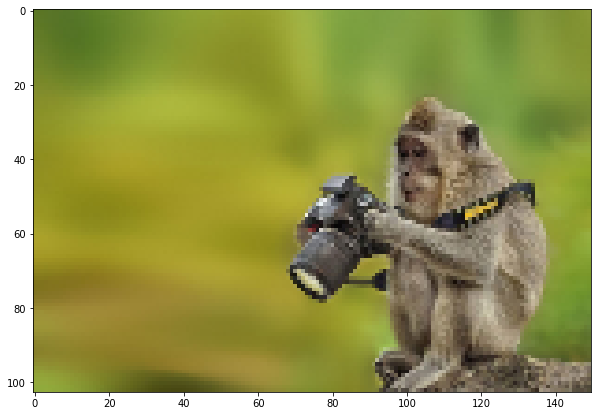

In [14]:
lr_image = cv2.resize(hr_image, 
                      dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4))

print(lr_image.shape)

plt.figure(figsize=(10,8))
plt.imshow(lr_image)

**3 줄인 저해상도 이미지를 SRGAN을 이용해 고해상도 이미지를 생성**
- 학습된 모델 불러오기

In [17]:
# 미리 학습된 모델 불러오기
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [18]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image) # lr_image로 변경

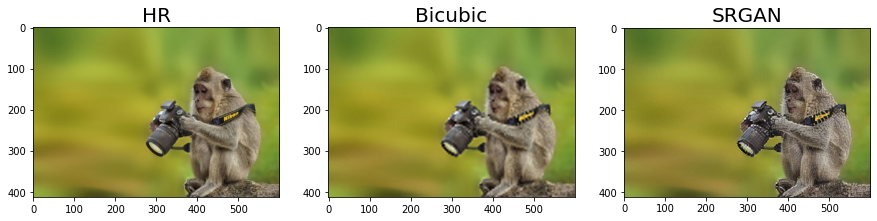

In [19]:
# Bicubic
def re_upsample(image):
    upsample = cv2.resize(
        lr_image,
        dsize=(hr_image.shape[1], hr_image.shape[0]),
        interpolation=cv2.INTER_CUBIC
    )
    return upsample

images = [hr_image, re_upsample(lr_image), srgan_hr]
titles = ['HR','Bicubic','SRGAN']

plt.figure(figsize=(15,10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

**3. 특정 부분을 잘라내어 시각화**

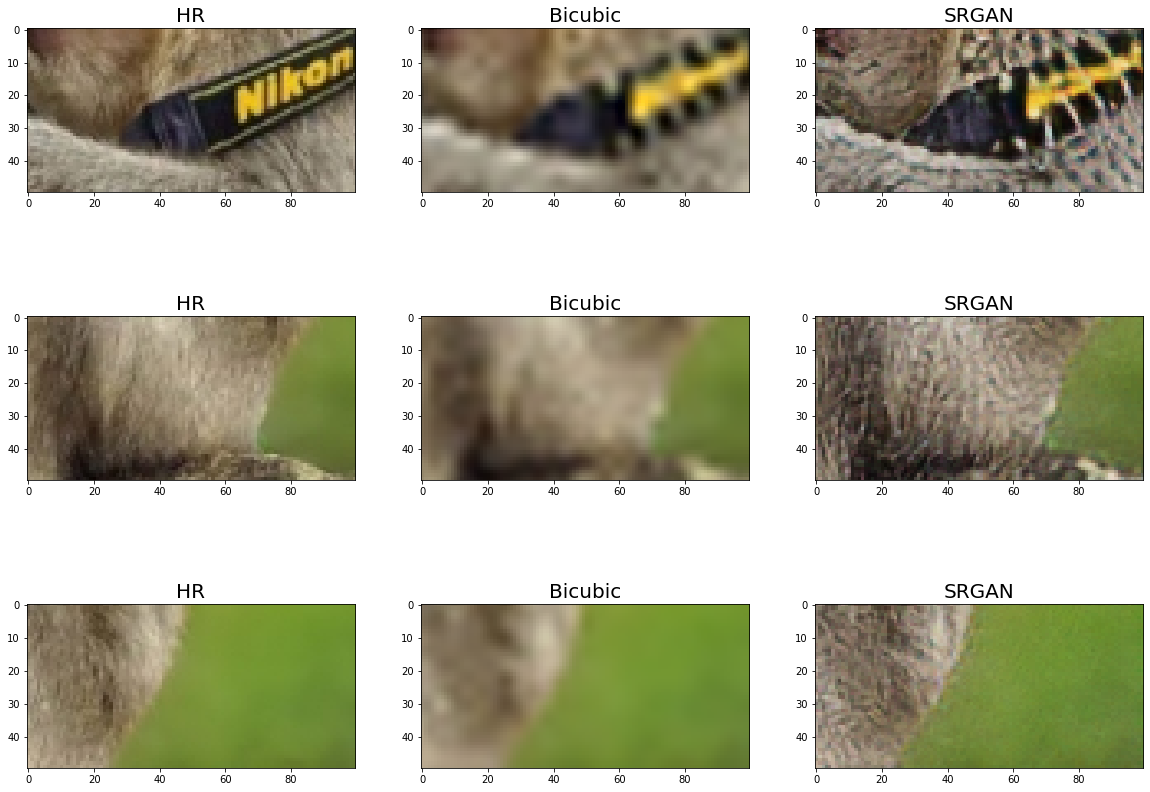

In [21]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(200,400)] *3 + [(330,450)] *3 + [(300,500)] *3

plt.figure(figsize=(20,15))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

- 3가지 중에서 오른쪽에서 왼쪽 순으로 사진의 해상도가 떨어진다.  
- 부분을 확대해서 가장 매끄럽게 보이는 것이 HR과 Bicubic이고, SRGAN이 제일 매끄럽지 않다.


### 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

**1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.**

(413, 600, 3)


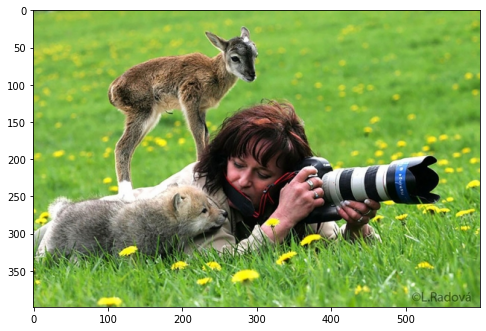

In [22]:
low_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/mo2.jpg')
low_image = cv2.cvtColor(low_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(8, 6))
plt.imshow(low_image)

**2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다.**

In [23]:
srgan_hr = apply_srgan(low_image)

**3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.**

**4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.**

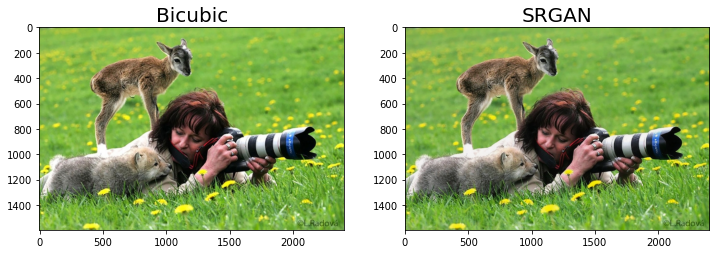

In [24]:
# 위에서 함수를 잘못 정의해서 다시 bicubic interpolation을 만든다.
bicubic_hr = cv2.resize(low_image, 
    dsize=(low_image.shape[1]*4, low_image.shape[0]*4), # 루브릭 조건 4배 늘리기
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 시각화
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12, 12))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

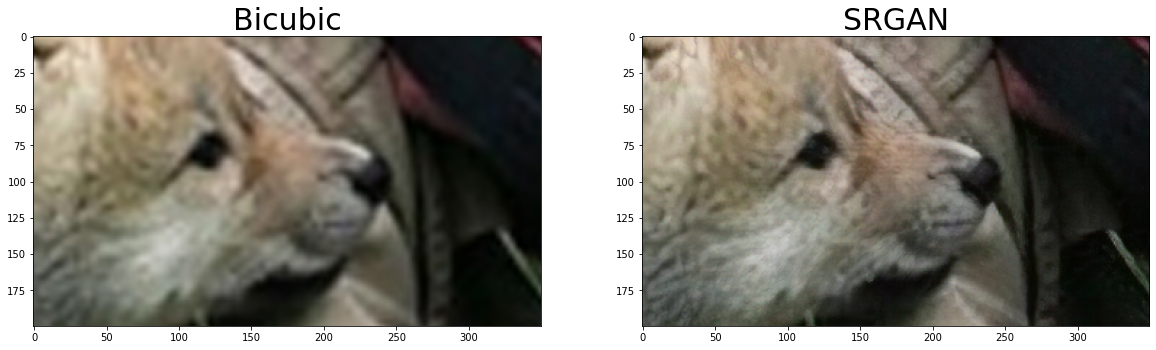

In [26]:
# 시각화를 통한 확인
images = [bicubic_hr, srgan_hr]
titles = ['Bicubic','SRGAN']

left_top = (1000,800) # 잘라낼 부분 좌표지정

plt.figure(figsize=(20,20))
for i, pind in enumerate([321, 322]):
    plt.subplot(pind)
    plt.imshow(crop(images[i], left_top, 200, 350))
    plt.title(titles[i], fontsize=30)

In [ ]:
- 이번에는 Bicubic보다 SRGAN이 더 뚜렸하게 나왔다. 하지만 전에 알아 보았던 HR보다는 선명도/해상도가 떨어진다는 것을 알 수 있었다. 

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기
-  이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행
- 실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요된다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 본다. 

**각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치**

In [27]:
! pip install imageio

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### 2-1. gif 파일 불러오기
아래 주소에 몇 개의 gif 파일이 있습니다. 이 중 하나를 골라 다운 로드하여 아래 과정을 수행합시다. (한 개 이상의 gif 파일에 대해 아래 과정을 수행해야 합니다!)
- GIF files https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e

- 다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있습니다. frames이란 리스트 안에 각각의 프레임이 들어 있습니다.

In [28]:
# 다운받은 파일의 경로를 설정해 주세요.
import os
import cv2

path = os.getenv('HOME') + '/aiffel/super_resolution/image'
gif = cv2.VideoCapture(os.path.join(path, "fire_lr.gif"))

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 14
frame 크기 : (282, 300, 3)


### 2-2. 프레임별 Super Resolution 진행하기
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다.
Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어주세요.

In [29]:
#bicubic interpolation으로 가로, 세로 픽셀 수를 4배 늘림.
#결과를 frames_sr이라는 리스트에 넣기.

frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

In [30]:
#SRGAN으로 가로, 세로 픽셀 수 4배 늘림.
#결과를 frames_sr이라는 리스트에 넣기.

frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

### 2-3. 프레임을 합쳐 gif 만들기
위에서 frame_sr을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. 
Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요

In [31]:
import imageio

gif_dir = os.getenv('HOME') + '/aiffel/super_resolution/image'

imageio.mimsave(os.path.join(gif_dir, 'fire_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_dir, 'fire_hr_srgan.gif'), frames_sr_srgan)

### 2-4. Jupyter notebook에 gif 표시하기
아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출해 주시면 됩니다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해주시기바랍니다. Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해주세요. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정해주세요.

In [ ]:
from IPython.display import Image as show_gif

show_gif(os.path.join(gif_dir, 'fire_lr.gif'), width=800)

In [ ]:
show_gif(os.path.join(gif_dir, 'fire_hr_bicubic.gif'), width=800)

In [ ]:
show_gif(os.path.join(gif_dir, 'fire_hr_srgan.gif'), width=800)

- 파일이 너무 커서 이미지를 따로 첨부한다. 

## 프로젝트 정리
- 해상도 별로 나타내었을 때 차이를 느꼈지만 이미지가 뚜렸한 부분도 있지만 전체적으로 가우시안(흐림)이 껴있는 느낌을 많이 받았다.
- gif는 처음에 불러왔던 저해상도와 고해상도의 차이가 났다. 고해상도라고 해서 뚜렷하다기 보다는 조금 노이즈 또는 픽색의 모양이라고 할까? 그런 부분이 보였다.
- 이미지를 늘리고 줄이면 깨지기 마련인데 이런것들을 조금은 덜 깨지는 느낌을 받았다. 